In [1]:
%matplotlib widget
from itertools import islice
from math import pi, sqrt, tau
from numbers import Integral, Real
import numpy as np
from matplotlib import pyplot as plt

from repair_trace import repair_trace
from scenario import Dir, Scenario

In [3]:
verbose = False


def pa(a, label=''):
    if not verbose:
        return

    def fn(x):
        if isinstance(x, Real) and not isinstance(x, Integral):
            return f'{x:5}'
        else:
            return f'{x}'

    out = f'{label:7.7s}: '
    try:
        shape = a.shape
        if len(shape) == 0:
            out += f'{fn(a)}'
        elif len(shape) == 1:
            out += f'[{' '.join(fn(x) for x in a)}]'
        elif len(shape) == 2:
            out += f'[{'; '.join(' '.join(fn(x) for x in r) for r in a)}]'
        else:
            raise NotImplementedError(f'rank = {len(shape)}')
        out += f'  \N{GREEK SMALL LETTER RHO}={shape}'
    except AttributeError:
        out += fn(a)
    print(out)


class AbstractExtendedKalmanFilter:
    """Abstract EKF needs to be subclassed.  Subclass must provide
       instance variables or properties to implement h(x), H, I, F, Q, and R.
    """
    def __init__(self, x_initial, P_initial):
        self.initialize(x_initial, P_initial)

    def initialize(self, x_initial, P_initial):
        self.x = x_initial
        self.P = P_initial
        pa(x_initial, 'x_initial')
        pa(P_initial, 'P_initial')
        if verbose:
            print()

    def update(self, z):
        pa(z, 'z')

        # Predict
        F = self.F
        pa(F, 'F')
        x_predicted = np.matmul(F, self.x.T)
        pa(x_predicted, 'x_predicted')
        Q = self.Q
        pa(Q, 'Q')
        P_predicted = np.matmul(np.matmul(F, self.P), F.T) + Q
        pa(P_predicted, 'P_predicted')

        # Update
        hx = self.h(x_predicted)
        pa(hx, 'h(x)')
        y = z - hx
        pa(y, 'y')

        H = self.H
        S = np.matmul(np.matmul(H, P_predicted), H.T) + self.R
        pa(H, 'H')
        pa(H.T, 'H.T')
        pa(self.R, 'R')
        pa(S, 'S')

        K = np.matmul(P_predicted, H.T) / S
        pa(K, 'K')

        self.x = x_predicted + np.matmul(K, y)
        pa(self.x, 'new x')
        self.P = np.matmul(self.I - np.matmul(K, H), P_predicted)
        pa(self.P, 'new P')
        if verbose:
            print()
        return self.x


class TestEKF(AbstractExtendedKalmanFilter):
    def __init__(self):
        x_initial = np.array([0, 0])
        P_initial = np.identity(2) * 0.2
        super().__init__(x_initial, P_initial)

        self.I = np.identity(2)
        self.Q = np.zeros(shape=(2, 2))
        self.R = np.zeros(shape=(1, 1))

    # h - predicted measurement function
    def h(self, x):
        return np.array([x[0], 0])

    # Jacobian - partial derivative at x
    @property
    def H(self):
        return np.array([0.9, 0])

    # F - state transition matrix
    @property
    def F(self):
        return np.array([[1, 0], [0, 1]])

    # @property
    # def Q(self):
    #     return np.zeros(shape=(2, 2))

    # @property
    # def R(self):
    #     return np.array([[0]])
    

f = TestEKF()

x = f.update(z=np.array([1, 0]))
# x = f.update(z=1)
pa(x, 'ret x')

x = f.update(z=np.array([1, 0]))
# x = f.update(z=1)
pa(x, 'ret x')
x = f.update(z=np.array([1, 0]))
# x = f.update(z=1)
pa(x, 'ret x')


In [4]:
class TestLLMEKF(AbstractExtendedKalmanFilter):

    def __init__(self):
        omega0 = pi / 2000
        alpha0 = 0
        x_initial = np.array([omega0, alpha0])
        P_initial = np.array([[omega0 / 10, 0], [0, omega0 / 10]])
        super().__init__(x_initial, P_initial)
        self.I = np.identity(2)
        self.Q = np.array([[1e-6, 0], [0, 0.1]])
        self.R = np.array([[1 / 80_000**2]])
    
    def h(self, x):
        return np.array([pi / 2000, 0])

    @property
    def H(self):
        return np.array([-pi / (pi / 2000)**2, 0])

    @property
    def F(self):
        return np.array([[1, pi / 2000], [0, 1]])

f = TestLLMEKF()
for i in range(10):
    print(f.update(np.array([pi / 2000, 0])))


[0.0015708 0.       ]
[0.0015708 0.       ]
[0.0015708 0.       ]
[0.0015708 0.       ]
[0.0015708 0.       ]
[0.0015708 0.       ]
[0.0015708 0.       ]
[0.0015708 0.       ]
[0.0015708 0.       ]
[0.0015708 0.       ]


In [5]:
assert True, """I have a units problem.  In some cases, time is in clocks and
    in others it's in seconds.  I need to make the base filter always use
    seconds, and I need to do the conversion in a consistent place.

    three layers.
        - Fan Speed Estimator - uses clocks
        - Fan Speed EKF
        - Abstract EKF - uses seconds

    clocks come into the filter here.
        - fse.update
          - fan_ekf.initialize
            - abs_ekf.initialize
          - fan_ekf.update
            - abs_ekf.update
            - fan_ekf.h(), H, F, Q

    The fan speed EKF already has clock conversion stuff.  fse.update is
    the choke point.  So I should convert to seconds there.
    """

class FanSpeedEKF(AbstractExtendedKalmanFilter):

    "specialize the abstract extended Kalman filter to measure fan speed"

    def __init__(self, pulses_per_rev, clock_freq):
        super().__init__(None, None)
        self.radians_per_pulse = tau / pulses_per_rev
        self.clock_freq = clock_freq

    def initialize(self, dt0, dt1):
        if dt0 is None:
            return
        rpp = self.radians_per_pulse
        omega0 = rpp / dt1
        alpha0 = rpp / (dt1 - dt0) / dt0
        alpha0 = ((rpp / dt1) - (rpp / dt0)) / dt0
        # print(f'{omega0 = }')
        # print(f'{alpha0 = }, {dt1 = }, {dt0 = }')
        sigma2 = 1 / self.clock_freq**2
        x_initial = np.array([omega0, alpha0])
        P_initial = np.array([[sigma2, 0], [0, 0.1]])
        super().initialize(x_initial, P_initial)
        self.I = np.identity(2)
        self.R = 1 / self.clock_freq**2
        print(self.R)
        # self.R *= 1e+1

    def update(self, dt):
        self.dt = dt
        # print(f'fse.update: {dt = }')
        z = np.array([dt, 0])
        x = super().update(z)
        return x[0]

    def h(self, x):
        # print(f'h({x = })')
        return np.array([self.radians_per_pulse / x[0], 0])

    @property
    def H(self):
        return np.array([-self.radians_per_pulse / self.x[0]**2, 0])

    @property
    def F(self):
        return np.array([[1, self.dt], [0, 1]])

    @property
    def Q(self):
        # https://stats.stackexchange.com/a/585962
        return np.array([[1e-4, 0], [0, 1e0]]) * sqrt(self.dt)


PULSES_PER_REVOLUTION = 2
RAW_CLOCK_FREQ = 80_000_000
CLOCK_DIVISOR = 512
CLOCK_FREQ = RAW_CLOCK_FREQ // CLOCK_DIVISOR
# print(f'{CLOCK_FREQ = }')

class FanSpeedEstimator:

    def __init__(self):
        self.ekf = FanSpeedEKF(PULSES_PER_REVOLUTION, CLOCK_FREQ)
        self.first_edges = [0.0, 0.0, 0.0]
        self.valid_edges = 0
        self.prev_edge = 0

    def speed_rpm(self):
        if self.valid_edges < 3:
            return 0
        return self.ekf.x[0] * 60 / tau

    def update(self, edge_clk, edge_direction):
        if edge_direction != Dir.RISING:
            return False
        edge_clk //= CLOCK_DIVISOR
        edge_sec = edge_clk / CLOCK_FREQ
        i = self.valid_edges
        if i < 3:
            edges = self.first_edges
            edges[i] = edge_sec
            i += 1
            self.valid_edges = i
            if i == 3:
                self.prev_edge = edge_sec
                dt0 = edges[1] - edges[0]
                dt1 = edges[2] - edges[1]
                # print(f'{dt0 = }, {dt1 = }')
                self.ekf.initialize(dt0, dt1)
                return False
        else:
            dt = edge_sec - self.prev_edge
            self.prev_edge = edge_sec
            self.ekf.update(dt)
            return True


global verbose
verbose = False
TRACE_FILE = '../traces/half-speed.trace'
fse = FanSpeedEstimator()
scen = Scenario(TRACE_FILE)
repair_trace(scen)
tach = scen.tach
o = 0
for (dir, clk) in islice(zip(tach.dir, tach.clk), 1000):
    edir = Dir(dir)
    o += edir == Dir.RISING
    if verbose:
        print(f'{(edir, clk) = }')
    fse.update(clk, edir)

print(o, 'pulses')

4.096e-11
234 pulses


4.096e-11


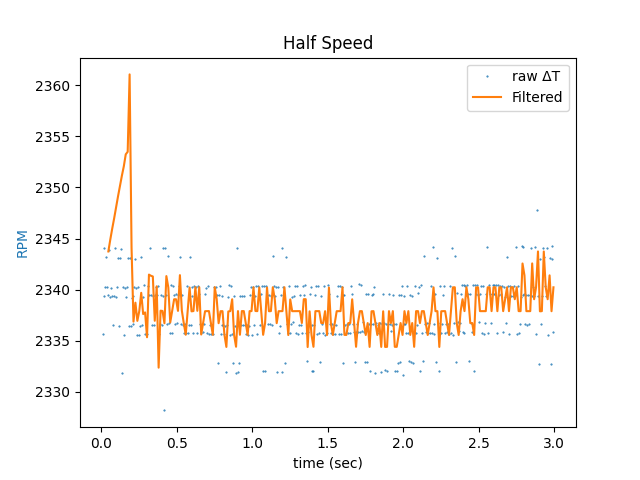

In [6]:
TRACE_FILE = '../traces/half-speed.trace'
RAW_CLOCK_PERIOD_sec = 1 / RAW_CLOCK_FREQ
global verbose
verbose = False

def raw_tach_points(scenario):
    clk = scenario.tach.clk
    x = clk[1:] * RAW_CLOCK_PERIOD_sec
    y = RAW_CLOCK_FREQ / np.diff(clk) * 60 / 2 / PULSES_PER_REVOLUTION
    return np.vstack([x, y]).T

def filtered_speed_points(scenario):
    fse = FanSpeedEstimator()
    tach = scenario.tach
    x, y = [], []
    for (dir, clk) in zip(tach.dir, tach.clk):
        if fse.update(clk, Dir(dir)):
            x.append(clk * RAW_CLOCK_PERIOD_sec)
            y.append(fse.speed_rpm())
    return np.vstack([x, y]).T

scen = Scenario(TRACE_FILE)
repair_trace(scen)
tach_pts = raw_tach_points(scen)
fse_pts = filtered_speed_points(scen)

fig, axes = plt.subplots()
axes.set_title('Half Speed')
tach_points, = axes.plot(tach_pts[:,0], tach_pts[:,1], '.', markersize=1, label='raw \N{GREEK CAPITAL LETTER DELTA}T')
axes.plot(fse_pts[:,0], fse_pts[:,1], label='Filtered')
axes.set_xlabel('time (sec)')
axes.set_ylabel('RPM', color=tach_points.get_color())
axes.legend()
plt.show()

4.096e-11


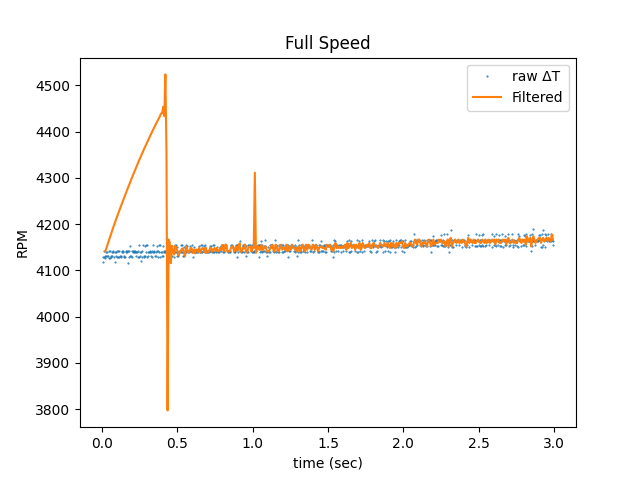

4.096e-11


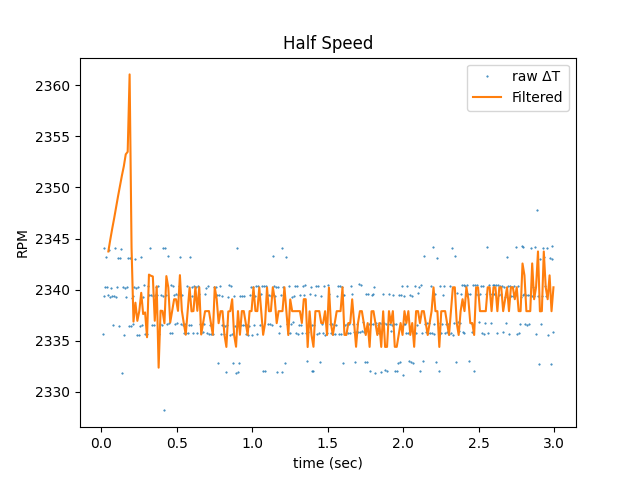

4.096e-11


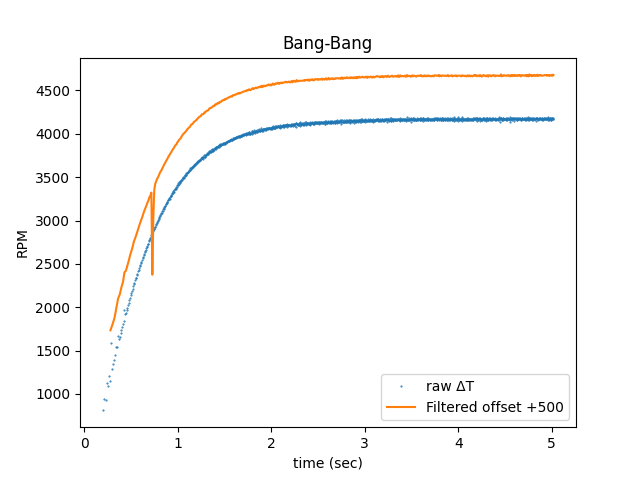

Ramps scenario: unstable PWM timing
   895 samples at 40.0125 usec
   1151 samples at 40.025 usec
   1 samples at 80.0 usec
   1151 samples at 39.975 usec
   895 samples at 39.9875 usec


4.096e-11


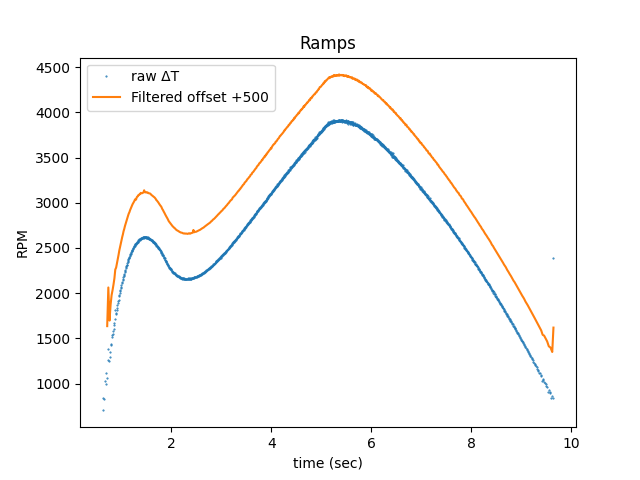

Staircase scenario: unstable PWM timing
   6 samples at 45.0 usec
   6 samples at 35.0 usec


4.096e-11


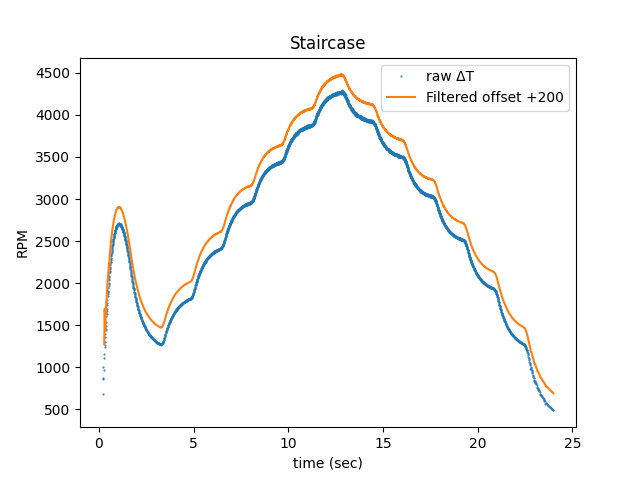

In [7]:
def plot_scenario(trace_file, png_file=None, offset=0):
    scen = Scenario(trace_file)
    repair_trace(scen)
    tach_pts = raw_tach_points(scen)
    fse_pts = filtered_speed_points(scen)

    fig, axes = plt.subplots()
    axes.set_title(scen.title)
    axes.plot(tach_pts[:,0], tach_pts[:,1], '.', markersize=1, label='raw \N{GREEK CAPITAL LETTER DELTA}T')
    fse_title = 'Filtered'
    if offset:
        fse_title = f'{fse_title} offset {offset:+}'
    axes.plot(fse_pts[:,0], fse_pts[:,1] + offset, label=fse_title)
    axes.set_xlabel('time (sec)')
    axes.set_ylabel('RPM')
    axes.legend()
    if png_file:
        fig.savefig(png_file, dpi=600)
    plt.show()

scenarios = [
    ('full-speed', 0),
    ('half-speed', 0),
    ('bang-bang', 500),
    ('ramps', 500),
    ('staircase', 200),
]
for sc, offset in scenarios:
    trace_file = f'../traces/{sc}.trace'
    png_file = f'{sc}.png'
    plot_scenario(trace_file, png_file, offset)
# plot_scenario('../traces/half-speed.trace')
# plot_scenario('../traces/bang-bang.trace', offset=500)
# plot_scenario('../traces/ramps.trace', offset=500)
# plot_scenario('../traces/staircase.trace', offset=200)
